# Table Detection using Faster RCNN
This project aims to perform **Documents Tables Detection** on UNLV dataset using Deep Learning. 

The proposed methodology for carrying out Table Detection in Documents consists of Faster Region based Convolutional Neural Network (Faster RCNN) for detection as its basic element. Faster RCNN is further divided into several layers where each layer contribute to detection. Faster RCNN is composed of following layers:

- Feature Extraction Layer to extract features from images
- Region Proposal Network (RPN) Layer that gives proposals for different set of regions in an image
- Region of Interest Layer that filters out from the proposed regions based on threshold

Following are the libraries that we will import.

In [1]:
# Import Libraries
# !pip install tensorflow-gpu==2.0.0alpha0
import pandas as pd
from PIL import Image

import numpy as np
import random
import os
import os
import cv2
import tensorflow as tf
from tensorflow.keras import losses
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import math
import random
from keras.utils.generic_utils import Progbar
# from keras.backend import image_dim_ordering
from keras.backend import image_data_format
import copy
import matplotlib.pyplot as plt
import hyperparameters

2022-12-14 10:02:26.659865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yash/Desktop/Courses/CS1430/cv_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-14 10:02:26.659881: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Download Data
First, we need the data. For this project, we will download and extract the **UNLV dataset**. The dataset can be downloaded from the link [here](https://drive.google.com/file/d/1ETq5hhoIgCzzom6yivkokhQ8DoOm6nDs/view?usp=sharing). 

In [2]:
# Download data from local repository
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/document-table-detection


# !mkdir data_fasterrcnn
# !cp -r "/content/gdrive/MyDrive/document-table-detection/train_val_test_data"

#Unzip data
#!unzip /content/gdrive/MyDrive/document-table-detection/train_val_test_data.zip

## Data Preprocessing

### Load Ground Truth CSV Files
After downloading the dataset, we can see that there is an `images` folder and two csv files i.e. `train.csv` and `test.csv`. The next step is to load both the csv files into pandas dataframe for easy indexing.

The code below loads the csv files into pandas dataframe.

### Resize Images and Bbox Coordinates
As the original images are much larger in size such that the smallest width and the smallest height is 2544px.  This may cause memory overflow during training. Also the images are all not of same size, so we will resize the images to 256 x 256 pixels and resize the bounding box coordinates according to it.

Following code resize the images and bounding box coordinates.

In [3]:
RUNNING_LOCALLY = True

In [4]:
if RUNNING_LOCALLY:
    # data_path = "/content/gdrive/MyDrive/document-table-detection/train_data"
    data_path = "/home/yash/Desktop/Courses/CS1430/final_project/0_experiments/train_val_test_data/train_data"
    model_weights_save_path = '/home/yash/Desktop/Courses/CS1430/final_project/0_experiments/model_save_path/'
else:
    data_path = "/home/fall80/dataset/train_data"
    model_weights_save_path = '/home/fall80/model_save_folder/'


In [5]:
from preprocess import *
from data_load_resize import data_loading_and_resizing

In [6]:
# # Load CSV Files into DataFrames
# train_file = pd.read_csv('train.csv',names=['image_names','xmin','ymin','xmax','ymax','class'])
# test_file = pd.read_csv('test.csv',names=['image_names','xmin','ymin','xmax','ymax','class'])

# # Display DataFrames
# print("\nTraining Ground Truth")
# display(train_file.head())
# print("\nTesting Ground Truth")
# display(test_file.head())

In [7]:
training_images, train_bounding_boxes, testing_images, test_bounding_boxes = get_data(data_path)
# training_images, train_bounding_boxes, train_files, testing_images, test_bounding_boxes, test_files = get_data(data_path)
train_images, train_labels = data_loading_and_resizing(training_images, train_bounding_boxes)
test_images, test_labels = data_loading_and_resizing(testing_images, test_bounding_boxes)

# # Display DataFrames
# print("\nResized Training Ground Truth")
# display(train_images.head(10))
# print("\nResized Testing Ground Truth")
# display(test_file.head())


In [8]:
len(train_images)

363

### Analysis of train data layouts

In [9]:
train_df = pd.DataFrame(train_labels, columns=['xmin', 'ymin', 'xmax', 'ymax'])
train_df['width'] = train_df['xmax'] - train_df['xmin']
train_df['height'] = train_df['ymax'] - train_df['ymin']
train_df['h_w_ratio'] = train_df['height'] / train_df['width']
train_df.head()

,xmin,ymin,xmax,ymax,width,height,h_w_ratio
0,47,46,74,128,27,82,3.037037
1,28,85,50,167,22,82,3.727273
2,39,78,72,176,33,98,2.969697
3,157,23,172,241,15,218,14.533333
4,22,30,50,232,28,202,7.214286


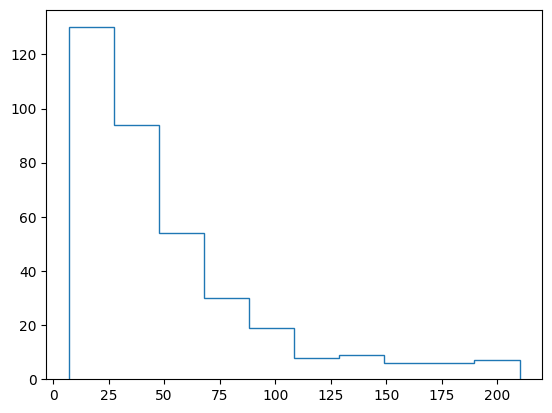

In [46]:
counts, bins = np.histogram(train_df['width'])
plt.stairs(counts, bins)

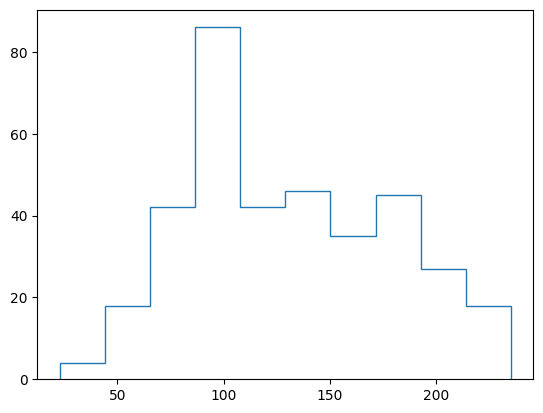

In [47]:
counts, bins = np.histogram(train_df['height'])
plt.stairs(counts, bins)

In [53]:
train_df['h_w_ratio'].sort_values().head(20)

25     0.412698
4      0.469388
62     0.490099
123    0.527094
353    0.529412
75     0.538889
106    0.572222
260    0.576087
205    0.676471
211    0.701987
150    0.702703
246    0.797872
122    0.805825
69     0.809524
283    0.813665
317    0.861538
31     0.866667
156    0.887931
6      0.894231
321    0.926829
Name: h_w_ratio, dtype: float64

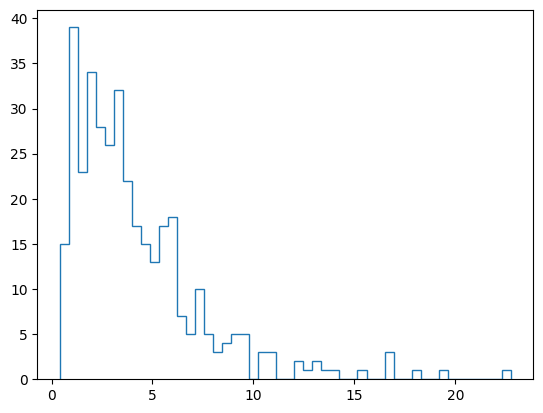

In [50]:
counts, bins = np.histogram(train_df['h_w_ratio'], bins=50)
plt.stairs(counts, bins)

We observe:
1. There are several boxes which are actually quite small
2. We note that while many boxes are squarish, most are taller than they are wide. The h/w ratio can be quite large in some cases
3. There are a few boxes which are wider than they are tall too, but quite few

### Data Visualization
Before generating the ground truth anchors, the most important task is to visualize the training and testing dataset.

In [9]:
# from visualize import visualize_doc
# print('Train Image Dataset')
# for i in range(len(train_images)):
#     visualize_doc(train_images[i], train_labels[i])

In [10]:
# print('Test Image Dataset')

# for i in range(len(test_images[:5])):
#     visualize_doc(test_images[i], test_labels[i])

### Generate Ground Truth Anchors
From above visualization we can see that the number of tables in a document image vary and therefore we cannot pass the bbox coordinates as ground truth in tensorflow model. In order to solve the variable length problem we will generate fixed number of anchors that serve as reference bounding boxes.

Following code generates fixed number of ground truth anchors for images.

In [10]:
from iou import calculate_iou
from rpn_features import calc_rpn, get_anchor_gt

## Define Model Layers
The model that is implemented in this project consists of following layers:

- Feature Extraction Layer to extract features from images
- Region Proposal Network (RPN) Layer that gives proposals for different set of regions in an image
- RPN to Region of Interest (RoI) Layer that convert the rpn proposals into different regions.
- Region of Interest Layer that filters out from the proposed regions based on threshold.


In [11]:
from model_architecture import *
model = ModelConfig(img_w=hyperparameters.image_width , img_h=hyperparameters.image_height, 
                    epochs=3, model_weights_save_path=model_weights_save_path, 
                    load_weight_path='/home/yash/Desktop/Courses/CS1430/final_project/0_experiments/model_save_path/')
model.model_initialize()
model.rpn_model.summary()

2022-12-14 10:02:49.932084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yash/Desktop/Courses/CS1430/cv_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-14 10:02:49.932111: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 10:02:49.932138: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yash-ThinkPad-L390): /proc/driver/nvidia/version does not exist
2022-12-14 10:02:49.932565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model (Functional)             (None, 16, 16, 512)  14714688    ['input_2[0][0]']                
                                                                                                  
 conv_rpn (Conv2D)              (None, 16, 16, 512)  2359808     ['model[0][0]']                  
                                                                                                  
 rpn_classify (Conv2D)          (None, 16, 16, 25)   12825       ['conv_rpn[0][0]']         

### Filter Regions Of Interest
Now for the final layer of the model, using the regions or bounding boxes picked in the last layer, we can now filter those regions that have an overlap greater than 0.65 with the ground truth boxes. However, for calculating the accuracy metric (intersection of union) we involve only those regions that have an overlap greater than 0.3 with the ground truth boxes.

In [12]:
def filter_roi(labels, Y_pred, thresh= 0.3):
    filter_labels = []
    iou_acc = []
    for label in labels:
        for predicted in Y_pred:
            label_iou = calculate_iou(label, predicted)
            if label_iou > thresh:
                iou_acc.append(label_iou)
                filter_labels.append(predicted)
      
    if iou_acc == []:
        mean = 0
    else:
        mean = np.mean(np.asarray(iou_acc))
    
    return filter_labels, mean 

# Testing filter_roi

In [12]:
# labels, Y_pred = labels, R_pred

In [13]:
filter_labels = []
iou_acc = []

In [28]:
label = labels[0]
label

array([ 24,  22,  66, 124])

In [29]:
Y_pred

array([[  0, 128,  32, 224],
       [  0,  32,  32, 128],
       [  0,  64,  32, 160],
       ...,
       [208, 112, 240, 176],
       [208,  32, 240,  96],
       [160, 160, 240, 224]])

In [30]:
predicted = Y_pred[0]

In [34]:
set([calculate_iou(label, Y_pred[i]) for i in range(Y_pred.shape[0])])

{0.0,
 0.0008959235478238045,
 0.0020210185931668332,
 0.003102149346160971,
 0.003273322421812149,
 0.003448275861474435,
 0.007228457294691437,
 0.009015256586509144,
 0.010493827159954021,
 0.012107870113909208,
 0.012116316638925935,
 0.015302218818802176,
 0.01539448364089248,
 0.017241379307782197,
 0.021099389225277706,
 0.022690437600275056,
 0.02508361203663829,
 0.0284023668611043,
 0.031407739760038175,
 0.031914893611362606,
 0.035571687839214404,
 0.03667321544913667,
 0.03783382789239544,
 0.03807106598639675,
 0.03888643393295554,
 0.041477209713832834,
 0.04301075268046402,
 0.04397905758778542,
 0.04779969650684119,
 0.04957507081567811,
 0.05373134328090889,
 0.05603735822948009,
 0.05886287624433731,
 0.060553633209262735,
 0.062289562286649384,
 0.06450511944842106,
 0.06980802791305875,
 0.07104194856714445,
 0.07355516636404624,
 0.0767205716362617,
 0.07831325300643192,
 0.0790729379551682,
 0.08202323990396047,
 0.0824333259817923,
 0.08481868469141474,
 0.08752

In [ ]:
for label in labels:
    for predicted in Y_pred:
        label_iou = calculate_iou(label, predicted)
        if label_iou > thresh:
            iou_acc.append(label_iou)
            filter_labels.append(predicted)
    
if iou_acc == []:
    mean = 0
else:
    mean = np.mean(np.asarray(iou_acc))


# Done Testing filter_roi

In [14]:
from get_roi_from_rpn import *

## Checking stuff

In [15]:
# trial = train_images[0]
# trial.min(), trial.max()
# trial2 = preprocess_input(trial)

# with open('/home/yash/Desktop/Courses/CS1430/final_project/0_experiments/trial.npy', 'rb') as f:
#     X_ = np.load(f, allow_pickle=True)
#     Y0_ = np.load(f, allow_pickle=True)
#     Y1_ = np.load(f, allow_pickle=True)
#     Y_ = [Y0_, Y1_]

## Done with Checking stuff

## Training

In [16]:
examples_in_epoch = len(train_images)
# examples_in_epoch = 5
loss_arr = np.zeros((examples_in_epoch, 3))
loss_cls = []
loss_regr = []
accuracy = []

# CHANGE THIS????
model.epochs = 10

In [17]:
for epoch_num in range(model.epochs):
    progbar = Progbar(examples_in_epoch)
    model.current_epoch = epoch_num
    print('Epoch {}/{}'.format(model.current_epoch + 1, model.epochs))

    data_gen_train = get_anchor_gt(train_images, train_labels)
    iter_num = 0
    epoch_start_time = time.time()
    while True:
        try:
            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, labels, index = next(data_gen_train)

            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model.rpn_model.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model.rpn_model.predict_on_batch(X)
            R_pred = infer_roi_from_rpn(model.anchor_box_scales, model.anchor_box_ratios, P_rpn[0], P_rpn[1], max_boxes=300, overlap_thresh=0.7)
            R_pred = R_pred * 16
            pred_labels, acc = filter_roi(labels, R_pred)

            loss_arr[iter_num, 0] = loss_rpn[1]
            loss_arr[iter_num, 1] = loss_rpn[2]
            loss_arr[iter_num, 2] = acc

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(loss_arr[:iter_num, 0])), 
                                        ('rpn_regr', np.mean(loss_arr[:iter_num, 1])),
                                        ('acc', np.mean(loss_arr[:iter_num, 2]))])
            
            if iter_num == examples_in_epoch:
                loss_rpn_cls = np.mean(loss_arr[:, 0])
                loss_rpn_regr = np.mean(loss_arr[:, 1])
                mean_iou = np.mean(loss_arr[:, 2])
                loss_cls.append(loss_rpn_cls)
                loss_regr.append(loss_rpn_regr)
                accuracy.append(mean_iou)
                epoch_end_time = time.time()
                model.epoch_times.append(epoch_end_time - epoch_start_time)
                iter_num = 0
                
                print('Loss RPN Classifier: ', loss_rpn_cls)
                print('Loss RPN Regressor: ', loss_rpn_regr)
                print('Mean IOU: ', mean_iou)

                # Save model
                model.save_model_weights(loss_cls, loss_regr, accuracy)

                break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue
        
print("Training complete!")

Epoch 1/10
363/363 [==============================] - 606s 2s/step - rpn_cls: 2.0030 - rpn_regr: 5.9123 - acc: 0.3526
Loss RPN Classifier:  1.5316242358333438
Loss RPN Regressor:  1.3424575818755815
Mean IOU:  0.37083690135643155
Epoch 2/10
363/363 [==============================] - 602s 2s/step - rpn_cls: 1.7891 - rpn_regr: 0.0924 - acc: 0.3858
Loss RPN Classifier:  1.5101587710635591
Loss RPN Regressor:  0.1046023295644527
Mean IOU:  0.3893846485136759
Epoch 3/10
363/363 [==============================] - 632s 2s/step - rpn_cls: 1.4636 - rpn_regr: 0.1542 - acc: 0.3712
Loss RPN Classifier:  1.2743741182246233
Loss RPN Regressor:  0.1210321879048688
Mean IOU:  0.3760124648849477
Epoch 4/10
363/363 [==============================] - 632s 2s/step - rpn_cls: 1.6009 - rpn_regr: 0.0581 - acc: 0.3898
Loss RPN Classifier:  1.418588110013575
Loss RPN Regressor:  0.059582423955778084
Mean IOU:  0.39205082116981105
Epoch 5/10
363/363 [==============================] - 626s 2s/step - rpn_cls: 1.6

KeyboardInterrupt: 

In [19]:
model.model_weights_save_path

'/home/yash/Desktop/Courses/CS1430/final_project/0_experiments/model_save_path/'

In [20]:
model.load_model_weights()

Loaded model weights successfully


# YM Note -> Check over
## have not tested anything below this

## Training and Testing Accuracy

In [ ]:
def calculate_accuracy(images, labels, losses):
  progbar = Progbar(338)
  print('Epoch 1/1')
  
  data_gen = get_anchor_gt(images, labels)
  iter_num = 0
  
  while True:
    try:
      
      # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
      X, Y, labels, index = next(data_gen)

      # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
      loss_rpn = model_rpn.train_on_batch(X, Y)

      # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
      P_rpn = model_rpn.predict_on_batch(X)
      R_pred = infer_roi_from_rpn(P_rpn[0], P_rpn[1], 'tf', use_regr=True, overlap_thresh=0.7, max_boxes=300)
      R_pred = R_pred * 16
      pred_labels, acc = filter_roi(labels, R_pred)

      losses[iter_num, 0] = loss_rpn[1]
      losses[iter_num, 1] = loss_rpn[2]
      losses[iter_num, 2] = acc

      iter_num += 1

      progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),('acc', np.mean(losses[:iter_num, 2]))])
      
      if iter_num == 338:
        return np.mean(losses[:, 1]), np.mean(losses[:, 2])
        break

    except Exception as e:
      print(e)
      continue

In [ ]:
train_losses = np.zeros((338, 3))
test_losses = np.zeros((338, 3))

_, train_acc = calculate_accuracy(train_images, train_labels, train_losses)
print("Training Accuracy: ", train_acc * 100)

_, test_acc = calculate_accuracy(test_images, test_labels, test_losses)
print("Testing Accuracy: ", test_acc * 100)

Epoch 1/1
338/338 [==============================] - 450s 1s/step - rpn_cls: 0.9070 - rpn_regr: 0.0359 - acc: 0.4154
Training Accuracy:  39.14981163013269
Epoch 1/1
338/338 [==============================] - 444s 1s/step - rpn_cls: 1.8081 - rpn_regr: 0.2197 - acc: 0.3982
Testing Accuracy:  41.04052254540981


## Loss Curves

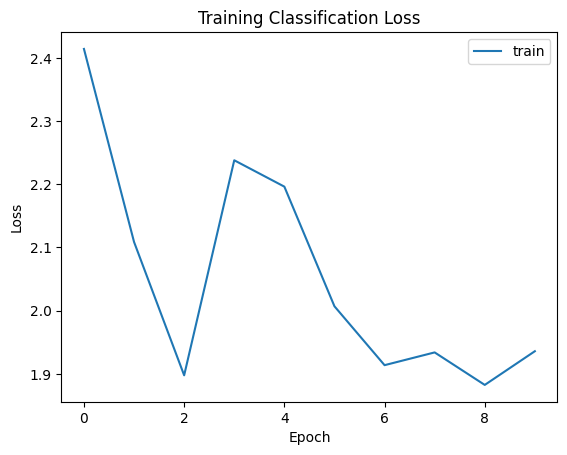

In [24]:
# Classification Loss
plt.plot(loss_cls)   
plt.title('Training Classification Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train']) 
plt.show()

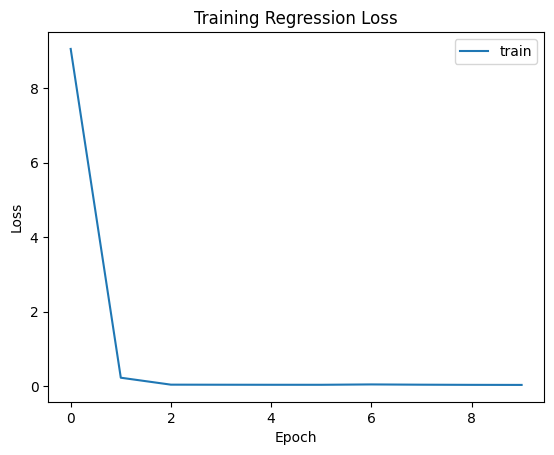

In [25]:
# Regression Loss
plt.plot(loss_regr)   
plt.title('Training Regression Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train']) 
plt.show()

## Accuracy Curves

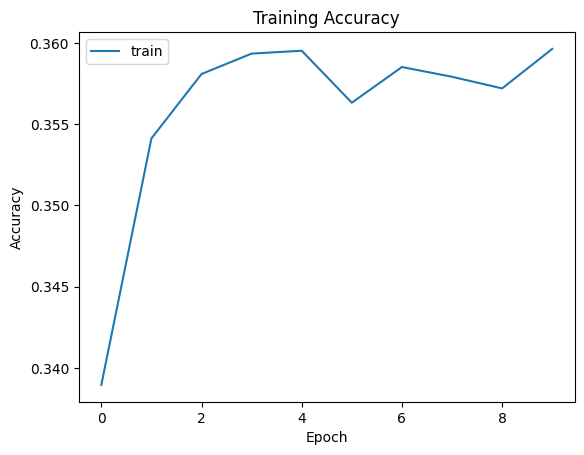

In [26]:
# Regression Loss
plt.plot(accuracy)   
plt.title('Training Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train']) 
plt.show()

## Testing

In [ ]:
def predict_labels(data_gen):
  X, Y, labels, index = next(data_gen)
  P_rpn = model_rpn.predict_on_batch(X)
  R_pred = rpn_to_roi(P_rpn[0], P_rpn[1], 'tf', use_regr=True, overlap_thresh=0.4, max_boxes=300)
  R_pred = R_pred * 16
  pred_labels, acc = filter_roi(labels, R_pred, 0.6)
  
  return pred_labels, index

def inference(data_gen, images):
  rows = 2
  columns = 3
  fig=plt.figure(figsize=(16, 12))
  for i in range(6):
    fig.add_subplot(rows, columns, i+1, xticks=[], yticks=[])
    labels, index = predict_labels(data_gen)
    image = images[index]
    for label in labels:
      cv2.rectangle(image,(label[0], label[1]),(label[2],label[3]),(255, 0, 0))
    plt.imshow(image)
  plt.show()

In [ ]:
data_gen_train = get_anchor_gt(train_images, train_labels)
data_gen_test = get_anchor_gt(test_images, test_labels)

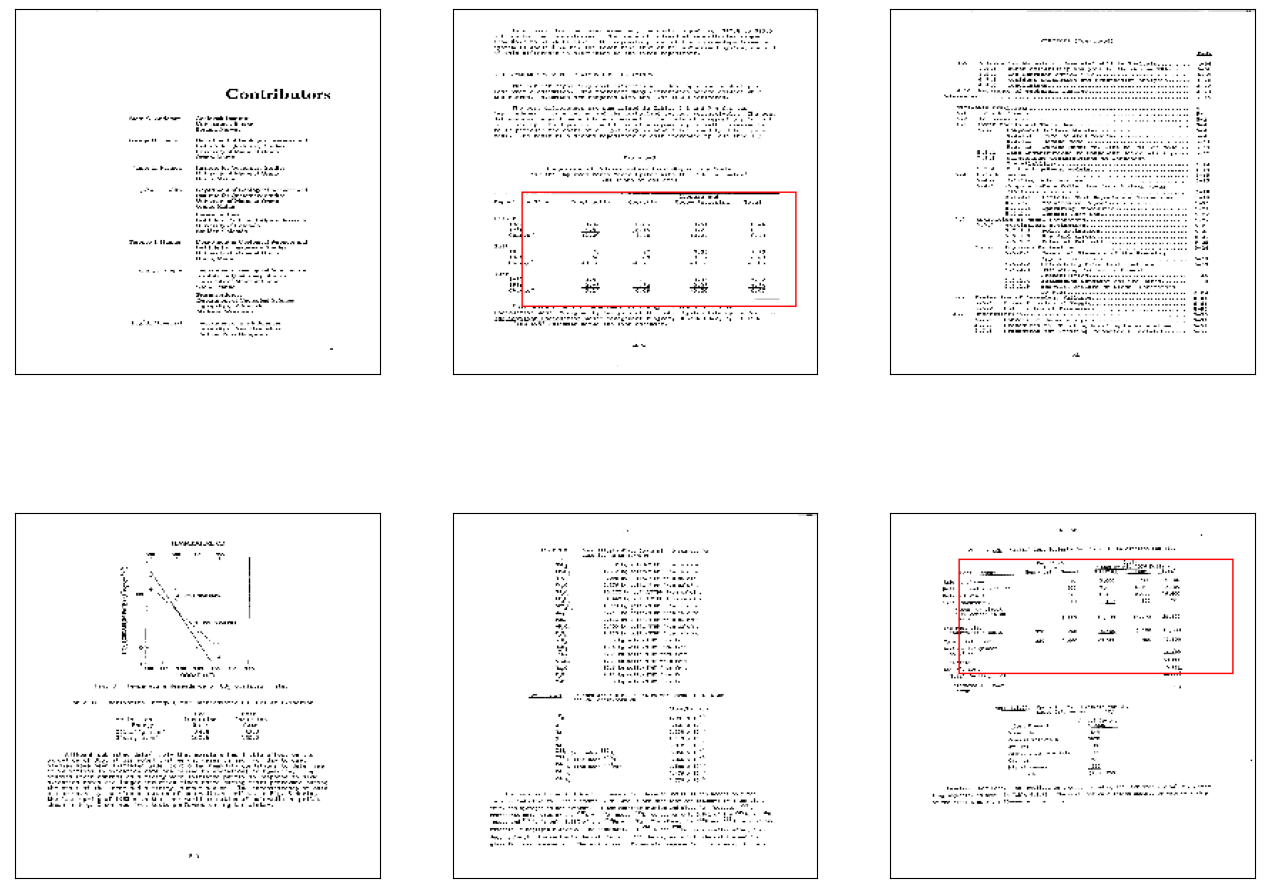

In [ ]:
inference(data_gen_train, np.copy(train_images))

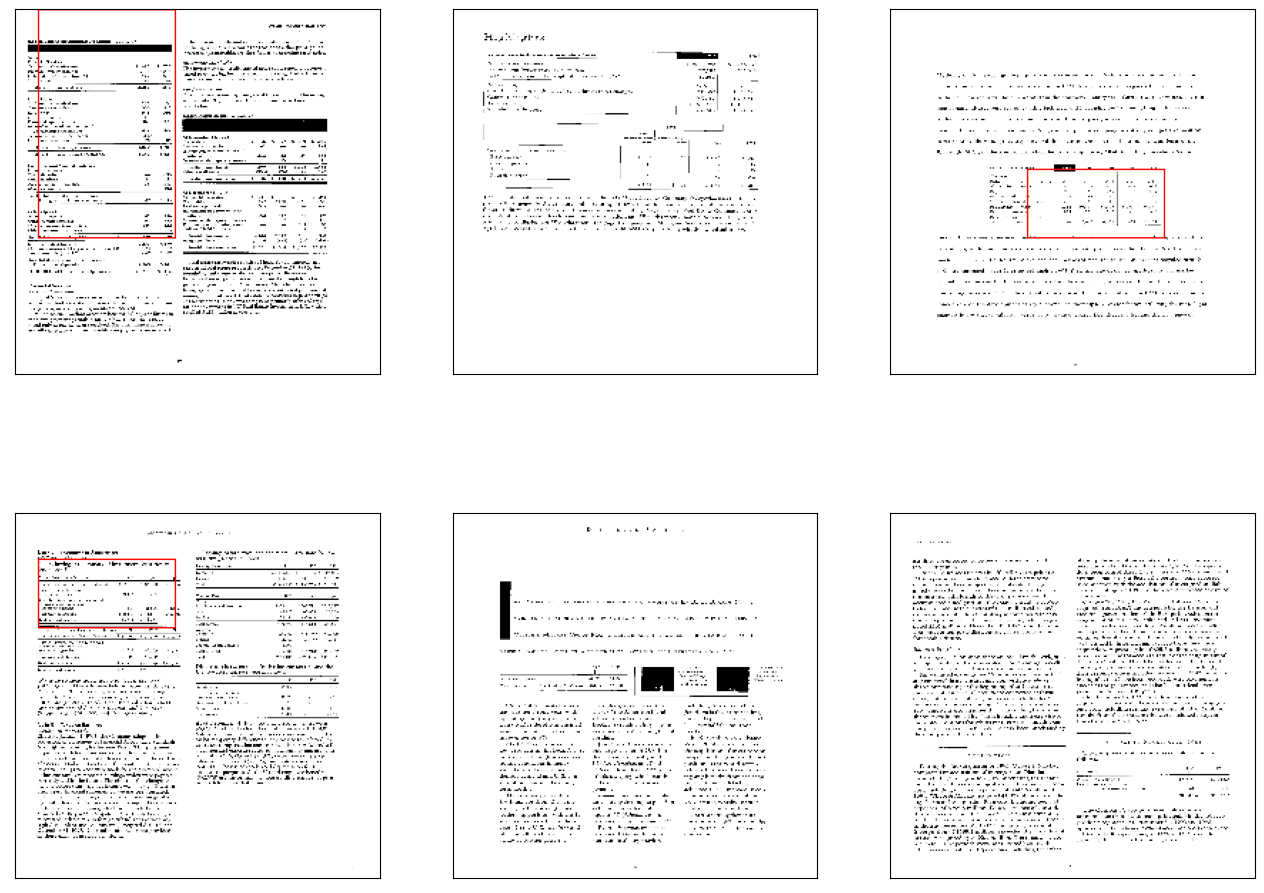

In [ ]:
inference(data_gen_test, np.copy(test_images))